# <center> Speech Emotion Recognition <center>


# Importing Libraries


In [24]:
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation

- As we are working with two different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
- We will use this dataframe to extract features for our model training.


In [25]:
# Paths for data.
Ravdess = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Song_Ravdess = "Audio_Song_Actors_01-24/"
Tess = "toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Crema = "cremad/AudioWAV/"

# <center> CREMA-D dataset </center>

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'angry'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'


In [26]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part = file.split("_")
    if part[2] == "SAD":
        file_emotion.append("sad")
    elif part[2] == "ANG":
        file_emotion.append("angry")
    elif part[2] == "DIS":
        file_emotion.append("disgust")
    elif part[2] == "FEA":
        file_emotion.append("fear")
    elif part[2] == "HAP":
        file_emotion.append("happy")
    elif part[2] == "NEU":
        file_emotion.append("neutral")
    else:
        file_emotion.append("Unknown")

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=["Path"])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,happy,cremad/AudioWAV/1030_IWW_HAP_XX.wav
1,happy,cremad/AudioWAV/1076_TIE_HAP_XX.wav
2,angry,cremad/AudioWAV/1065_IWL_ANG_XX.wav
3,happy,cremad/AudioWAV/1067_IEO_HAP_MD.wav
4,neutral,cremad/AudioWAV/1039_ITH_NEU_XX.wav


## Create Data_path Dataframe


In [27]:
# creating Dataframe using all the 2 dataframes we created so far.
data_path = Crema_df
data_path.to_csv("data_path.csv", index=False)
# Output result not include index column
data_path.head(10)

,Emotions,Path
0,happy,cremad/AudioWAV/1030_IWW_HAP_XX.wav
1,happy,cremad/AudioWAV/1076_TIE_HAP_XX.wav
2,angry,cremad/AudioWAV/1065_IWL_ANG_XX.wav
3,happy,cremad/AudioWAV/1067_IEO_HAP_MD.wav
4,neutral,cremad/AudioWAV/1039_ITH_NEU_XX.wav
5,sad,cremad/AudioWAV/1022_IEO_SAD_MD.wav
6,happy,cremad/AudioWAV/1054_WSI_HAP_XX.wav
7,fear,cremad/AudioWAV/1078_IWL_FEA_XX.wav
8,angry,cremad/AudioWAV/1022_IEO_ANG_LO.wav
9,neutral,cremad/AudioWAV/1084_IEO_NEU_XX.wav


## Data Visualisation and Exploration


First let's plot the count of each emotions in our dataset.


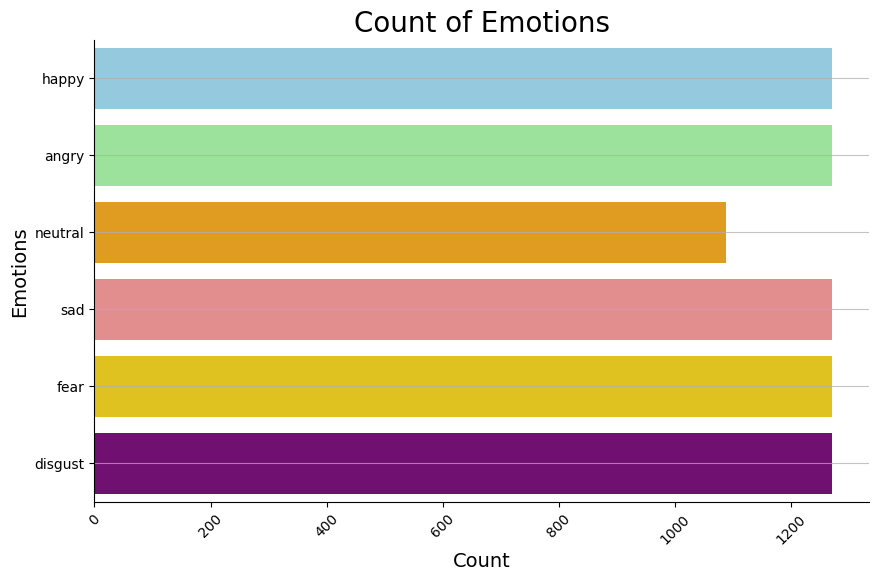

In [28]:
plt.figure(figsize=(10, 6))  # Điều chỉnh kích thước biểu đồ

colors = ["skyblue", "lightgreen", "orange", "lightcoral", "gold", "purple", "pink"]
ax = sns.countplot(data_path.Emotions, palette=colors)

plt.title("Count of Emotions", size=20)
plt.ylabel("Emotions", size=14)
plt.xlabel("Count", size=14)
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.75)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

- Waveplots - Waveplots let us know the loudness of the audio at a given time.
- Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.


In [29]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(12, 4))
    plt.title(f"Waveplot for audio with {e} emotion", size=15)
    plt.plot(data)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 4))
    plt.title("Spectrogram for audio with {} emotion".format(e), size=20)
    librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="hz", cmap="viridis")
    plt.xlabel("Time (s)", size=14)
    plt.ylabel("Frequency (Hz)", size=14)
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [30]:
# emotion = "surprise"
# path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
# data, sampling_rate = librosa.load(path)
# create_waveplot(data, sampling_rate, emotion)
# create_spectrogram(data, sampling_rate, emotion)
# Audio(path)

In [31]:
# emotion = "calm"
# path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
# data, sampling_rate = librosa.load(path)
# create_waveplot(data, sampling_rate, emotion)
# create_spectrogram(data, sampling_rate, emotion)
# Audio(path)

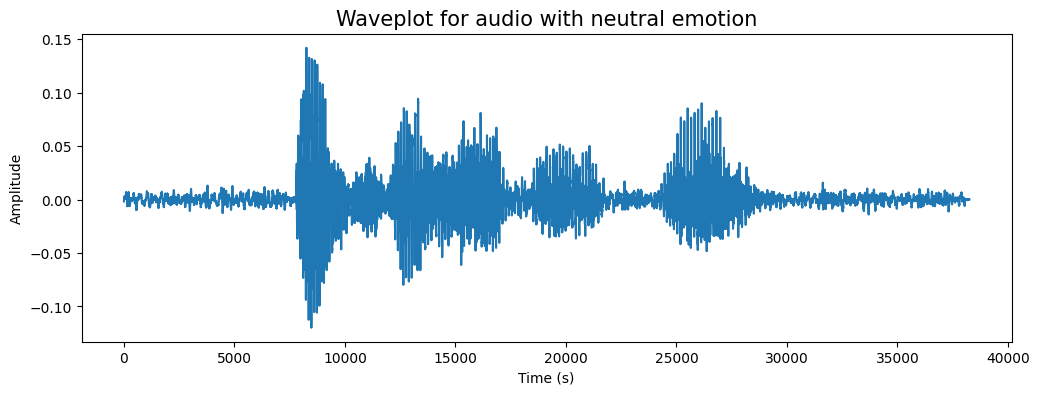

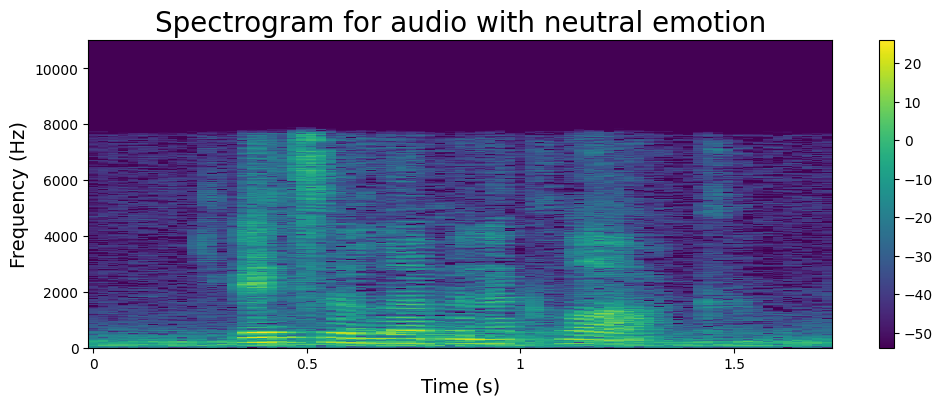

In [32]:
emotion = "neutral"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

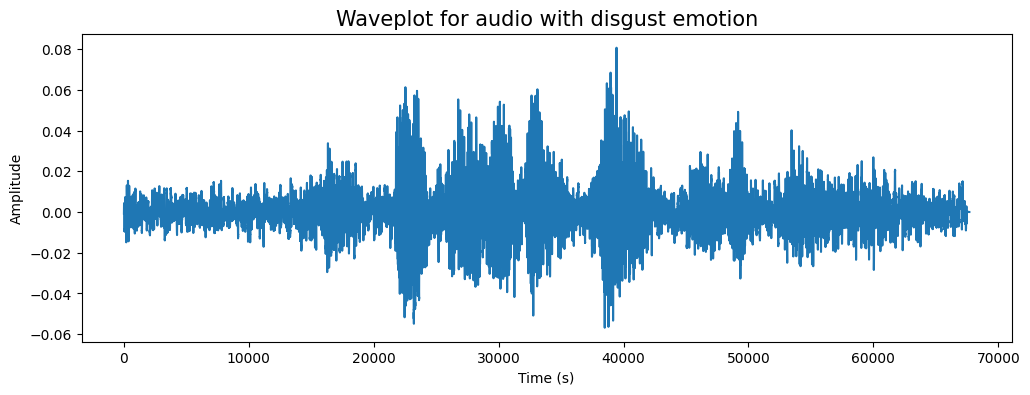

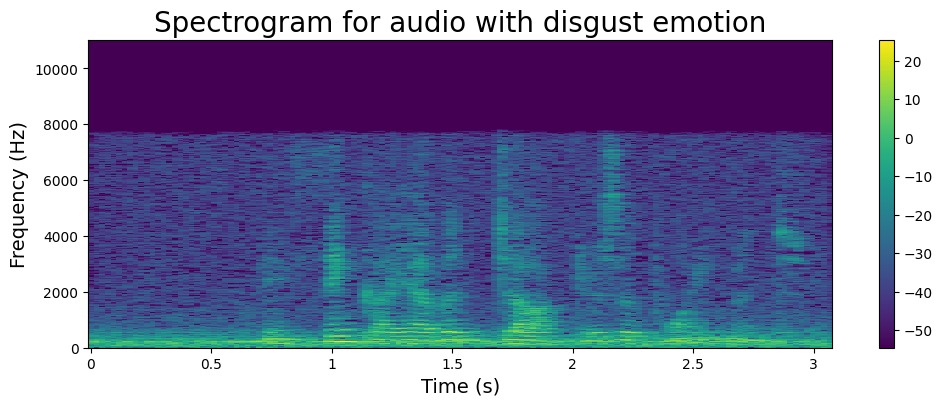

In [33]:
emotion = "disgust"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

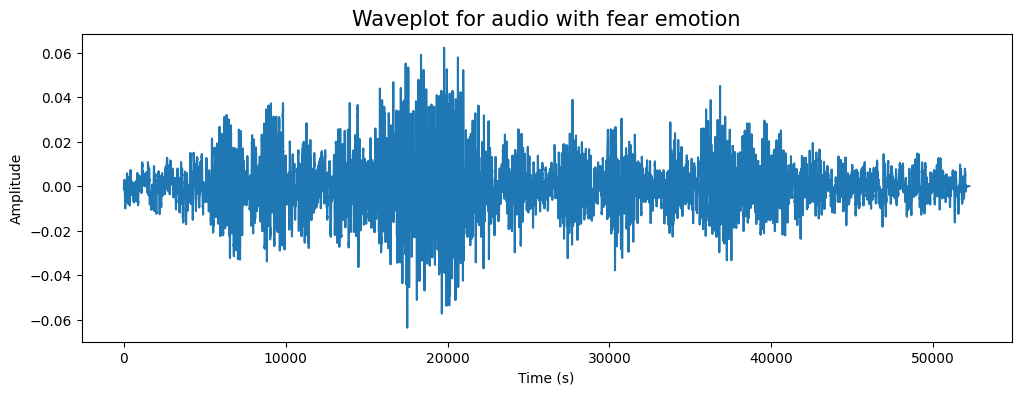

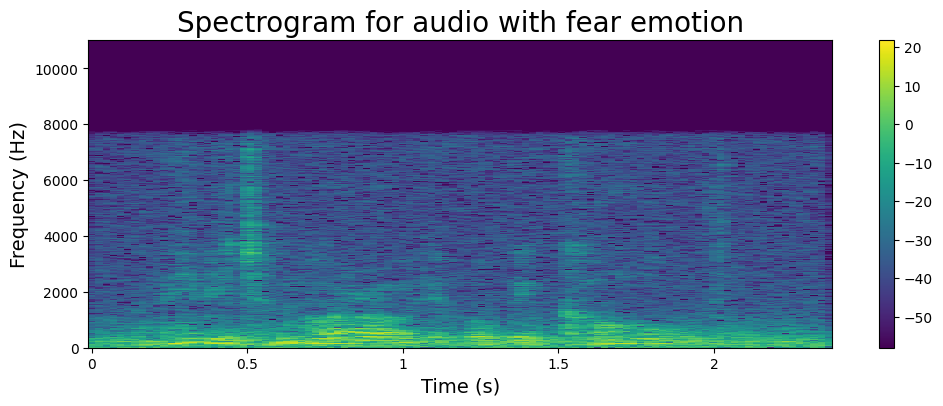

In [34]:
emotion = "fear"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

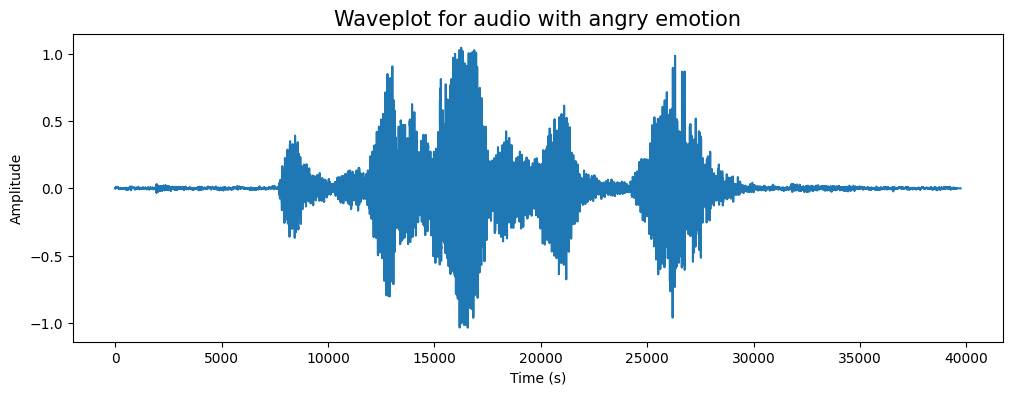

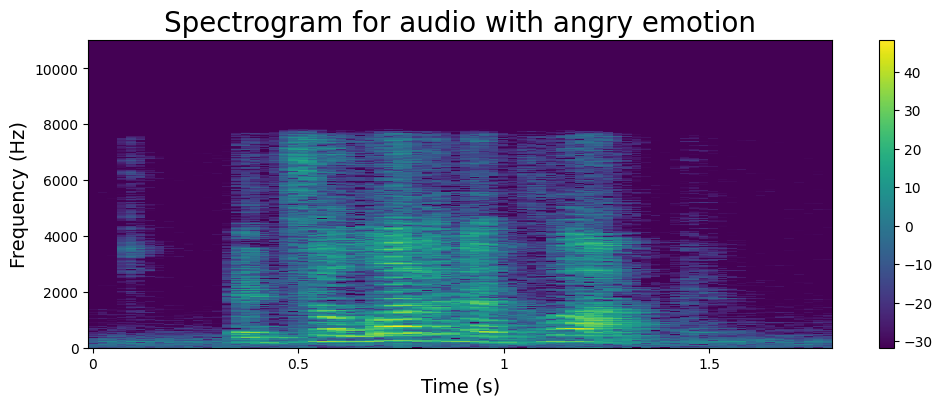

In [35]:
emotion = "angry"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

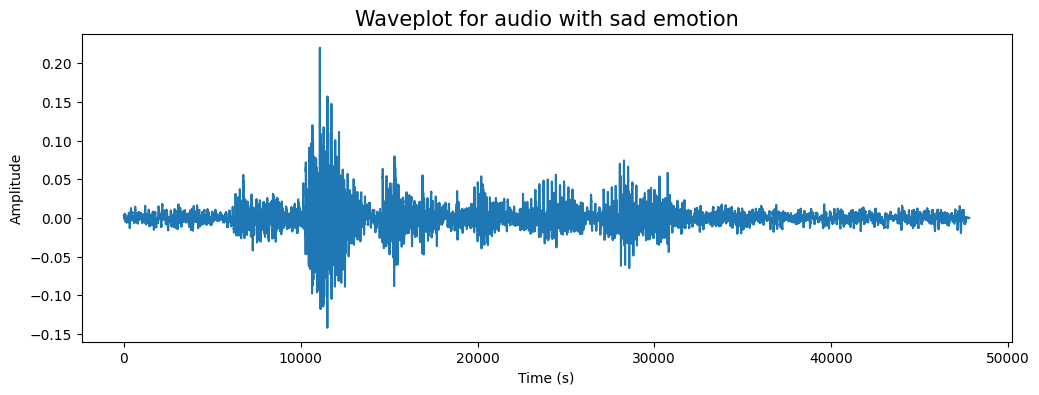

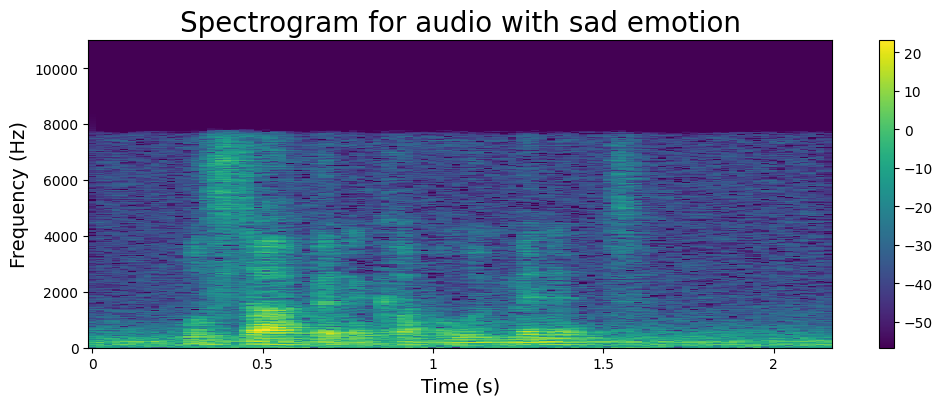

In [36]:
emotion = "sad"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

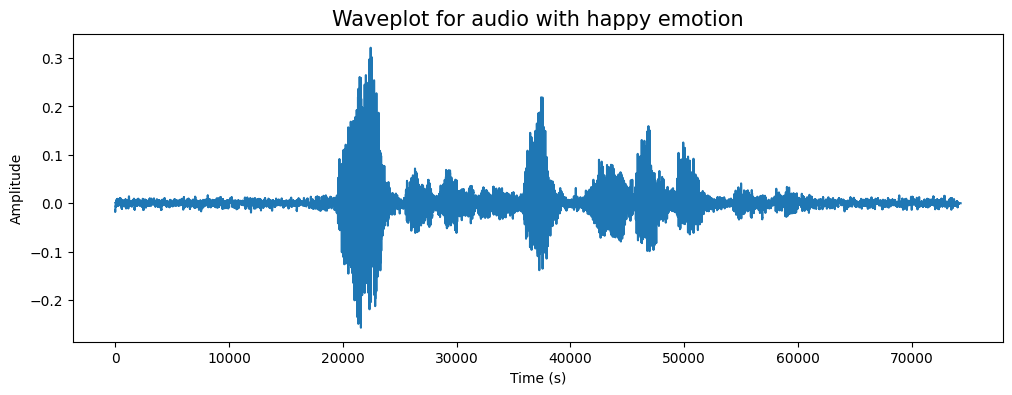

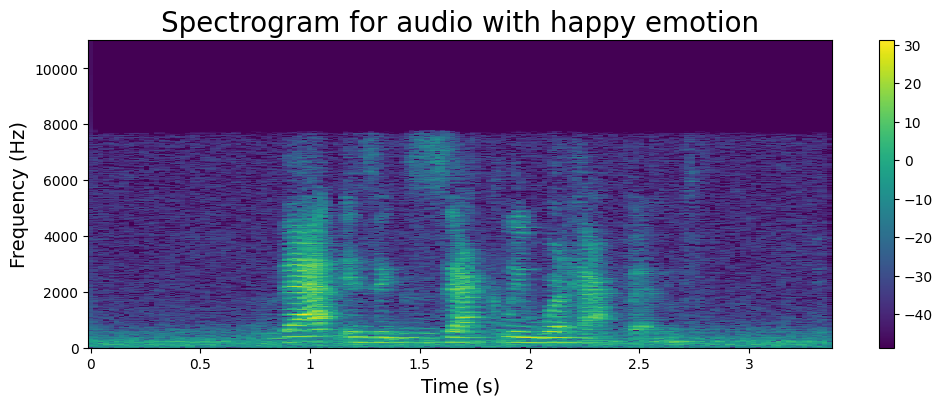

In [37]:
emotion = "happy"
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.


In [38]:
def noise(data):
    noise_amp = 0.04 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, n_steps):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)


# Taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [39]:
# print data type of data and sample_rate
print(len(data), sample_rate)

74310 22050


#### 1. Simple Audio


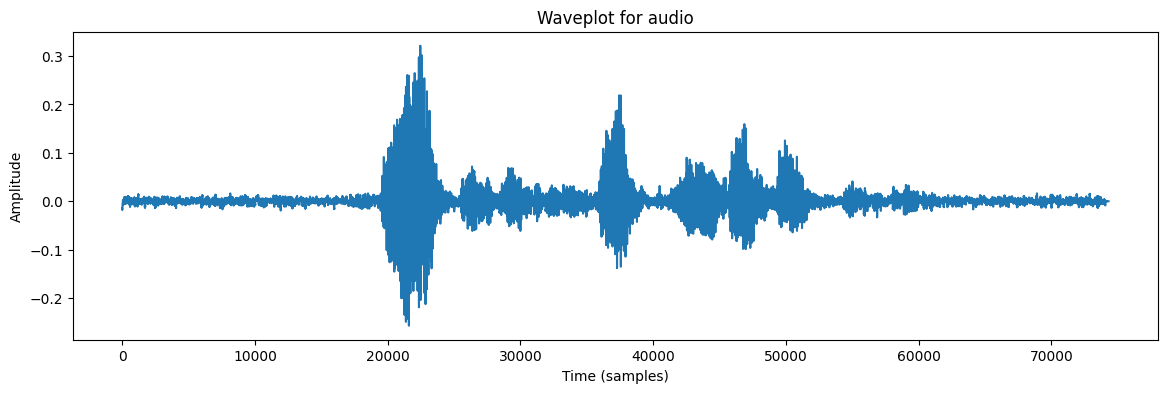

In [40]:
plt.figure(figsize=(14, 4))
plt.plot(data)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio")
plt.show()
Audio(path)

#### 2. Noise Injection


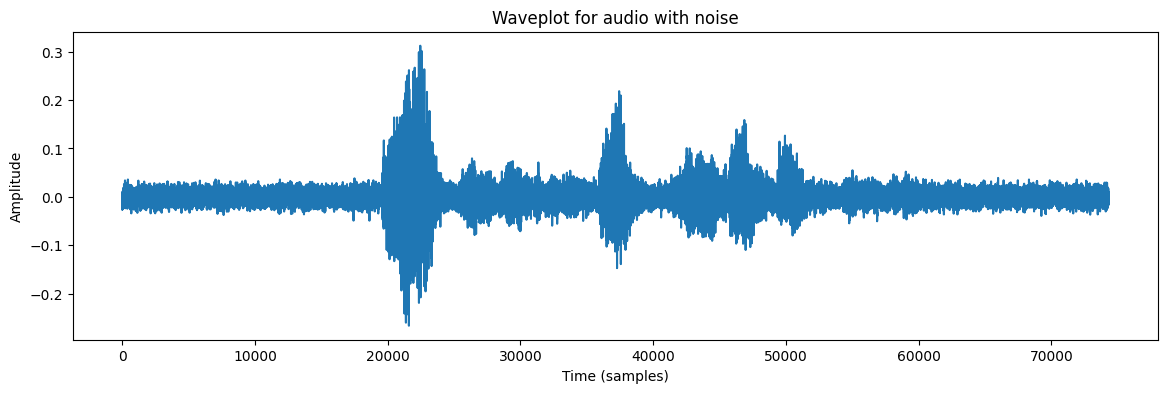

In [41]:
x = noise(data)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio with noise")
plt.show()
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted


#### 3. Stretching


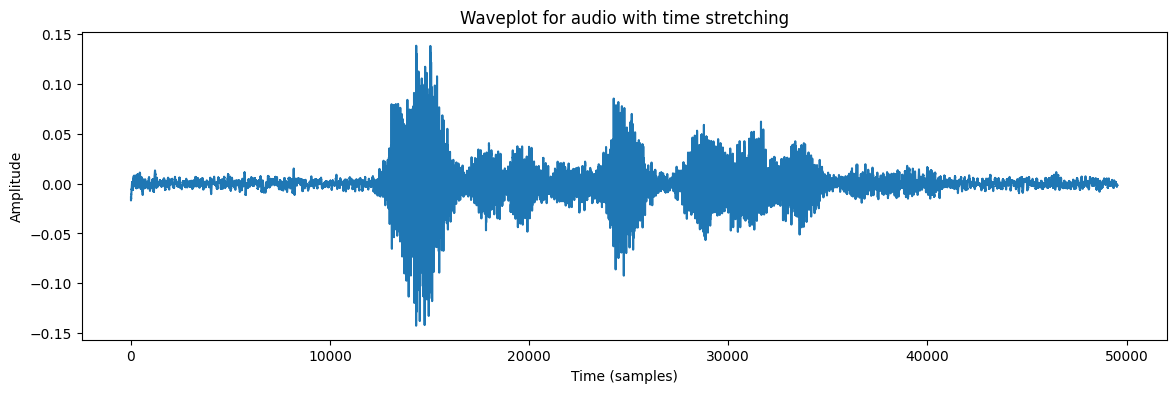

In [42]:
x = stretch(data, rate=1.5)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio with time stretching")
plt.show()
Audio(x, rate=sample_rate)

#### 4. Shifting


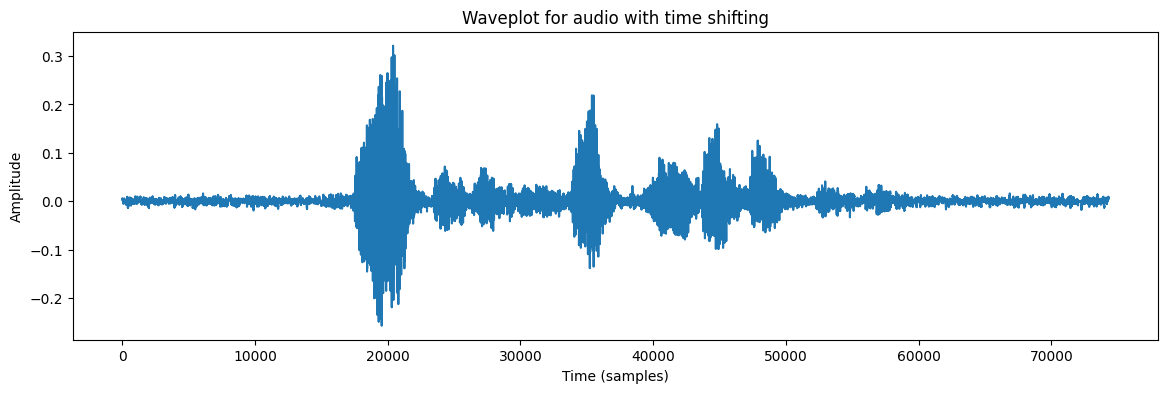

In [43]:
x = shift(data)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio with time shifting")
plt.show()
Audio(x, rate=sample_rate)

#### 5. Pitch


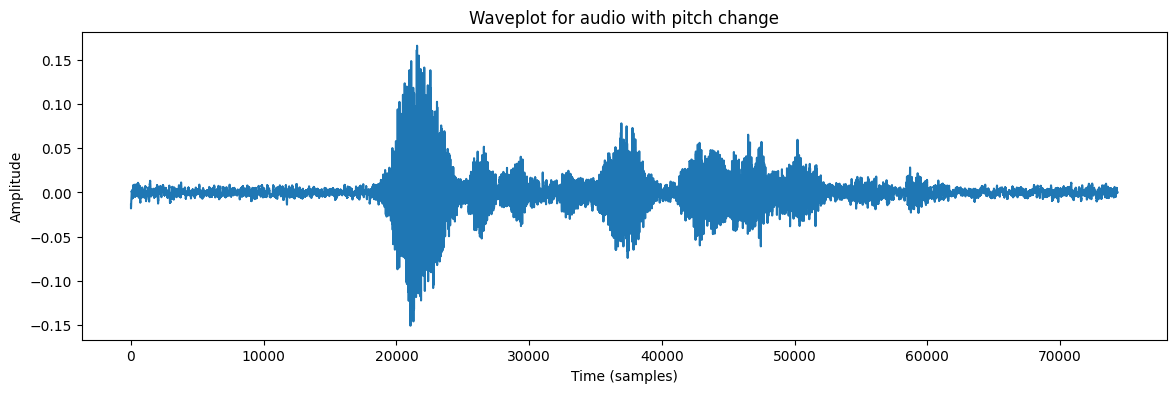

In [44]:
x = pitch(data, sample_rate, n_steps=-3)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveplot for audio with pitch change")
plt.show()
Audio(x, rate=sample_rate)

## Feature Extraction


In [45]:
def extract_features(data):
    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=30).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    return result


def get_features(path):
    # Duration and offset
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # Data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    # Data with stretching (low speed)
    lowspeed_data = stretch(data, rate=0.7)
    res3 = extract_features(lowspeed_data)
    result = np.vstack((result, res3))

    # Data with stretching (high speed)
    highspeed_data = stretch(data, rate=1.25)
    res4 = extract_features(highspeed_data)
    result = np.vstack((result, res4))

    # Data with pitching (high pitch)
    highpitch_data = pitch(data, sample_rate, n_steps=0.8)
    res5 = extract_features(highpitch_data)
    result = np.vstack((result, res5))

    # Data with pitching (low pitch)
    # lowpitch_data = pitch(data, sample_rate, n_steps=-0.8)
    # res6 = extract_features(lowpitch_data)
    # result = np.vstack((result, res6))

    # Data with shift
    shift_data = shift(data)
    res7 = extract_features(shift_data)
    result = np.vstack((result, res7))

    return result

In [46]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 6 times as we have made 6 augmentation techniques on each audio file.
        Y.append(emotion)

In [47]:
len(X), len(Y), data_path.Path.shape

(44652, 44652, (7442,))

In [48]:
Features = pd.DataFrame(X)
Features["labels"] = Y
Features.to_csv("features.csv", index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,labels
0,-347.793579,133.244843,-3.034060,47.742981,-18.084812,15.167846,-20.217270,-0.744317,-17.601257,1.199647,...,1.152208,-4.554378,4.975540,0.017188,3.204526,-3.367486,3.607702,-3.977260,1.592437,happy
1,-258.672317,67.309768,16.156691,16.650116,3.104493,-0.689653,-6.059364,-8.757601,-9.476757,-2.989375,...,-0.621912,-1.937322,1.614752,3.202321,1.156544,-0.913872,0.840251,-0.827136,0.401192,happy
2,-380.014587,129.681046,-3.885945,46.591995,-16.525656,14.788440,-20.378159,-2.419738,-17.878262,0.998261,...,1.000412,-4.684507,5.074213,0.256075,3.101048,-2.871075,3.199209,-3.756448,2.383617,happy
3,-375.685394,134.440308,-7.953519,47.381313,-19.851509,15.062472,-21.580715,-1.576651,-17.678350,2.069603,...,0.712428,-5.207233,5.682954,0.574161,3.344531,-3.471960,3.077615,-3.895050,2.730806,happy
4,-371.542267,127.938560,-1.898309,42.071499,-18.729717,12.135545,-22.376415,-1.210056,-17.714525,6.893185,...,-3.063774,1.851829,5.209654,-0.000811,-0.235296,-2.167621,1.755418,-3.367786,6.501641,happy


- We have applied data augmentation and extracted the features for each audio files and saved them.


## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.


In [49]:
X = Features.iloc[:, :-1].values
Y = Features["labels"].values

In [50]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [51]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 30), (33489, 6), (11163, 30), (11163, 6))

In [52]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 30), (33489, 6), (11163, 30), (11163, 6))

In [53]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((33489, 30, 1), (33489, 6), (11163, 30, 1), (11163, 6))

## Modelling


In [56]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()
model.add(
    Conv1D(
        256,
        kernel_size=5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(x_train.shape[1], 1),
    )
)
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(128, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=5, strides=2, padding="same"))

model.add(Flatten())
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 30, 256)           1536      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 15, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 8, 256)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 8, 128)            163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 4, 128)          

In [57]:
rlrp = ReduceLROnPlateau(
    monitor="loss", factor=0.4, verbose=0, patience=2, min_lr=0.0000001
)
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[rlrp],
)

Epoch 1/50


2024-06-14 22:32:37.312434: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


524/524 [==============================] - 8s 10ms/step - loss: 1.5846 - accuracy: 0.3203 - val_loss: 1.4659 - val_accuracy: 0.3910 - lr: 0.0010
Epoch 2/50
524/524 [==============================] - 5s 9ms/step - loss: 1.4689 - accuracy: 0.3940 - val_loss: 1.4061 - val_accuracy: 0.4269 - lr: 0.0010
Epoch 3/50
524/524 [==============================] - 5s 9ms/step - loss: 1.4225 - accuracy: 0.4199 - val_loss: 1.3835 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 4/50
524/524 [==============================] - 5s 9ms/step - loss: 1.3924 - accuracy: 0.4349 - val_loss: 1.3450 - val_accuracy: 0.4541 - lr: 0.0010
Epoch 5/50
524/524 [==============================] - 5s 9ms/step - loss: 1.3569 - accuracy: 0.4543 - val_loss: 1.3229 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 6/50
524/524 [==============================] - 5s 9ms/step - loss: 1.3243 - accuracy: 0.4699 - val_loss: 1.3021 - val_accuracy: 0.4753 - lr: 0.0010
Epoch 7/50
524/524 [==============================] - 5s 9ms/step - loss: 1.2918

349/349 [==============================] - 1s 3ms/step - loss: 0.9208 - accuracy: 0.7126
Accuracy of our model on test data :  71.26220464706421 %


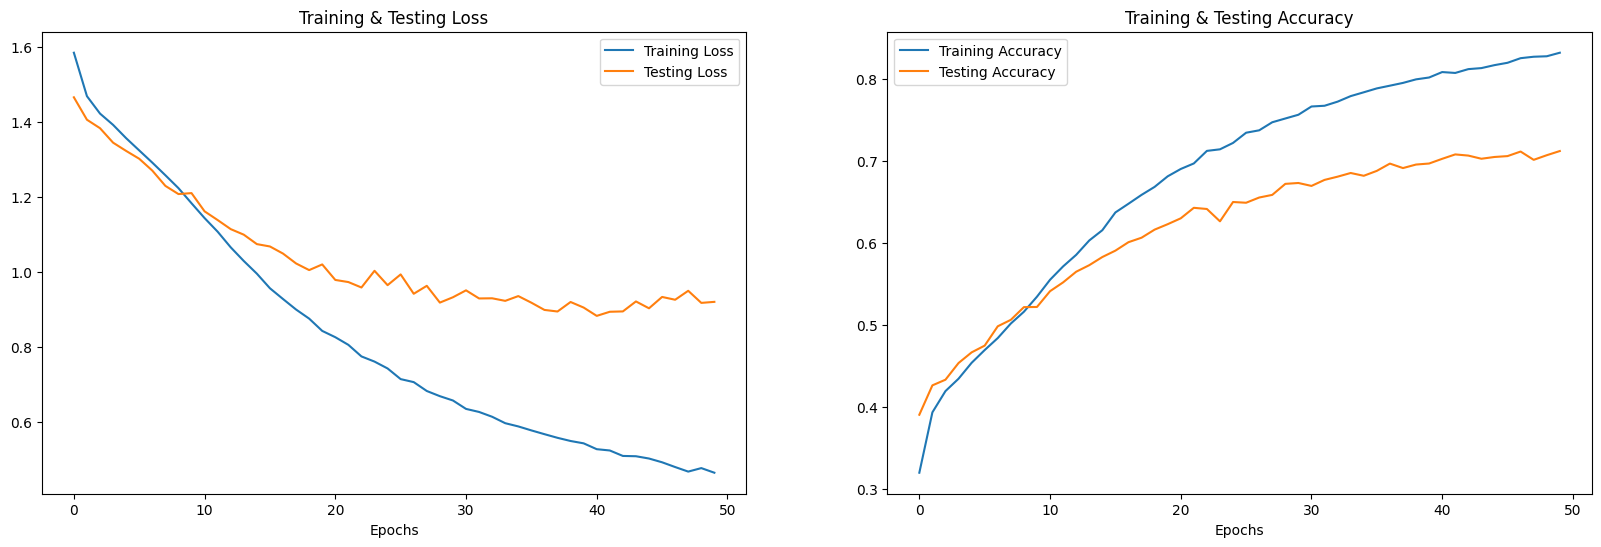

In [58]:
print(
    "Accuracy of our model on test data : ",
    model.evaluate(x_test, y_test)[1] * 100,
    "%",
)

epochs = [i for i in range(50)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
test_acc = history.history["val_accuracy"]
test_loss = history.history["val_loss"]

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label="Training Loss")
ax[0].plot(epochs, test_loss, label="Testing Loss")
ax[0].set_title("Training & Testing Loss")
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label="Training Accuracy")
ax[1].plot(epochs, test_acc, label="Testing Accuracy")
ax[1].set_title("Training & Testing Accuracy")
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [59]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

349/349 [==============================] - 1s 2ms/step


In [60]:
df = pd.DataFrame(columns=["Predicted Labels", "Actual Labels"])
df["Predicted Labels"] = y_pred.flatten()
df["Actual Labels"] = y_test.flatten()

df.head(1000)

,Predicted Labels,Actual Labels
0,sad,sad
1,sad,sad
2,sad,sad
3,disgust,disgust
4,happy,happy
...,...,...
995,fear,fear
996,disgust,sad
997,angry,angry
998,sad,happy


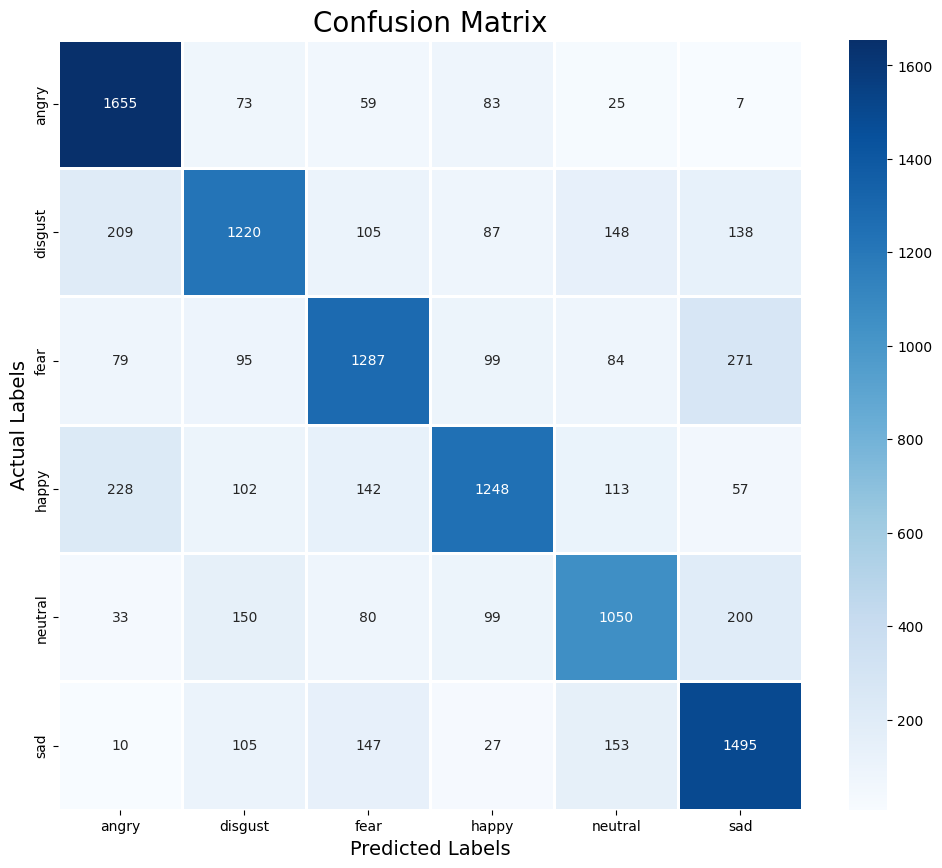

In [61]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(
    cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_]
)
sns.heatmap(cm, linecolor="white", cmap="Blues", linewidth=1, annot=True, fmt="")
plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted Labels", size=14)
plt.ylabel("Actual Labels", size=14)
plt.show()

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.87      0.80      1902
     disgust       0.70      0.64      0.67      1907
        fear       0.71      0.67      0.69      1915
       happy       0.76      0.66      0.71      1890
     neutral       0.67      0.65      0.66      1612
         sad       0.69      0.77      0.73      1937

    accuracy                           0.71     11163
   macro avg       0.71      0.71      0.71     11163
weighted avg       0.71      0.71      0.71     11163

